# Example 5.2 — Modeling Carbon-Film Resistor Degradation

**Author:** Justin Ryan  
**Created:** 2025-09-24  
**Updated:** 2025-10-07  
**Version:** 1.1  

---
## Problem Statement
This example involves modeling the performance degradation of carbon-film resistors over time under different 
stress conditions — specifically, three different temperature levels. The resistance of each resistor increases 
with time as it degrades. The resistance measurements over time at three temperature levels are provided in 
**Table 5.2** and **Table 5.3** (Meeker, Escobar, and Pascual, 2022).  

A resistor is considered to have **failed** when its resistance has increased by **5% or more** from its initial value.  
We are interested in the following:  

1. **Model the increase in resistance** over time for each temperature level.  
2. **Explore appropriate model forms** based on the observed degradation trends.  
3. For each resistor, **determine the time to 5% resistance increase** using the fitted degradation model.  
4. **Convert observed degradation data** into estimated failure times (pseudo time-to-failures).  
5. Use the **Accelerated Life Testing (ALT)** approach to fit a probability distribution (e.g., Weibull, lognormal) 
   to the pseudo failure times.  
6. **Evaluate goodness of fit** and select the distribution that best models the resistor’s life under 
   **normal usage conditions (50 °C / 323 K)**.  


## Method

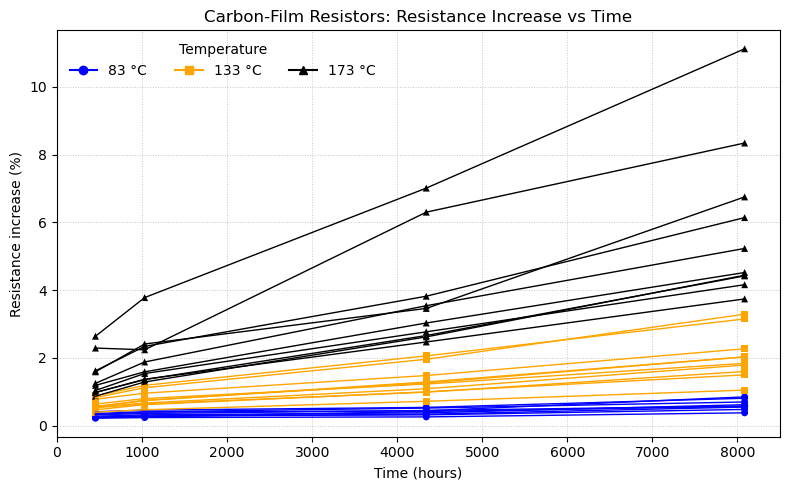

In [55]:
# 0) Load data and basic preprocessing
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import arviz as az
import scipy.stats as st

from scipy.optimize import least_squares, brentq, minimize
from scipy.stats import norm, linregress,weibull_min, gamma, lognorm
from reliability.Fitters import Fit_Everything, Fit_Weibull_2P, Fit_Gamma_2P, Fit_Lognormal_2P


df = pd.read_csv("Example_5.2_resistor_data.csv")
#df = df[~df["Unit"].isin([22, 26])].reset_index(drop=True)

# --- Tidy (long) format for plotting ---
time_cols = ['h_452', 'h_1030', 'h_4341', 'h_8084']
time_map = {'h_452': 452, 'h_1030': 1030, 'h_4341': 4341, 'h_8084': 8084}

# # Modified to drop transitent behaviour less than 1030h
# time_cols = ['h_1030', 'h_4341', 'h_8084']
# time_map = {'h_1030': 1030, 'h_4341': 4341, 'h_8084': 8084}

long = df.melt(
    id_vars=['Unit', 'Temperature_C'],
    value_vars=time_cols,
    var_name='time_label',
    value_name='pct_increase'
).dropna(subset=['pct_increase'])

long['hours'] = long['time_label'].map(time_map).astype(int)
# display(long)
# Final arrays (keep names explicit to avoid shadowing)
t_time = long["hours"].to_numpy(float)
T_acc_K = long["Temperature_C"].to_numpy(float)+273.15
D_obs = long["pct_increase"].to_numpy(float)
T_degC = long["Temperature_C"].to_numpy(float)

# --- Plot styling ---
TEMP_COLORS = {83: 'blue', 133: 'orange', 173: 'black'}
TEMP_MARKERS = {83: 'o', 133: 's', 173: '^'}

fig, ax = plt.subplots(figsize=(8, 5))

# Plot by temperature, then by unit (solid lines only)
for temp, gtemp in long.sort_values(['Temperature_C', 'Unit', 'hours']).groupby('Temperature_C'):
    color = TEMP_COLORS.get(temp, 'tab:gray')
    marker = TEMP_MARKERS.get(temp, 'o')

    for unit, gunit in gtemp.groupby('Unit'):
        gunit = gunit.sort_values('hours')
        ax.plot(gunit['hours'].values, gunit['pct_increase'].values, label=None, linewidth=1, color=color, linestyle='-')
        ax.scatter(gunit['hours'].values, gunit['pct_increase'].values, s=25, marker=marker, edgecolors='none', color=color)
        
# Temperature legend (one entry per temperature)
handles = []
labels = []
for t in [83, 133, 173]:
    if (long['Temperature_C'] == t).any():
        h = ax.plot([], [], color=TEMP_COLORS[t], marker=TEMP_MARKERS[t], linestyle='-', linewidth=1.5)[0]
        handles.append(h)
        labels.append(f'{t} °C')

ax.legend(handles, labels, title='Temperature', frameon=False, ncol=3, loc='upper left')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Resistance increase (%)')
ax.set_title('Carbon-Film Resistors: Resistance Increase vs Time')
ax.set_xlim(0, 8500)
ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
# plt.yscale("log")
plt.tight_layout()
plt.show()


LSQ params: gamma0=0.14831, gamma1=0.000932207, Ea=0.421228
RMS residual: 0.879276


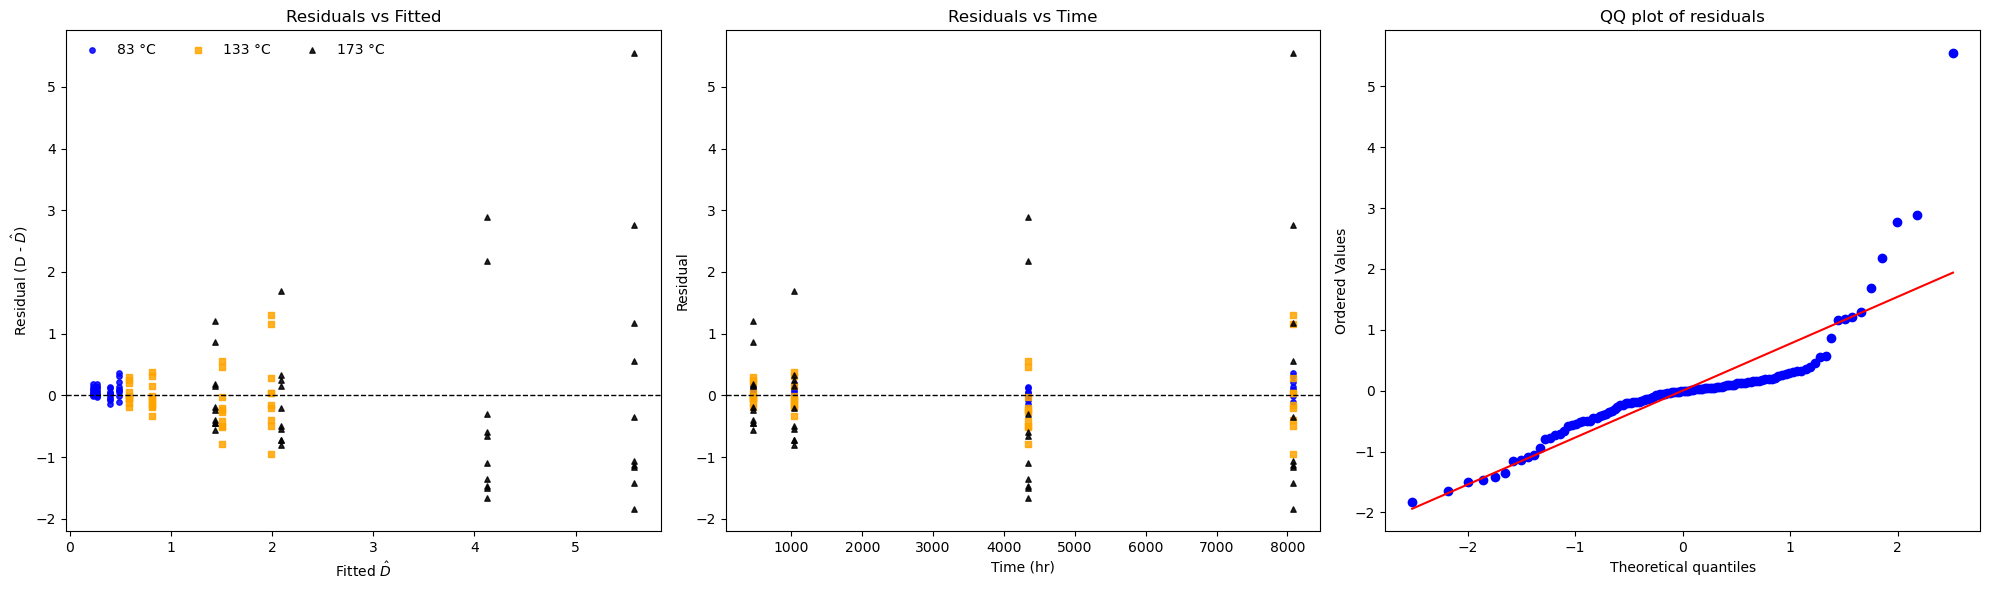

In [2]:
# 1) LSQ estimation of physics-informed degradation model
# -----------------------------

T_use = 323.15              # 50 °C in Kelvin
K_eV_perK = 8.617e-5        # Boltzmann const (eV/K)

# Use Kelvin in the exp term
# T_acc_K should be Temperature_C + 273.15 as float

def mu_D(params, t, T_accK, T_use=T_use):
    gamma0, gamma1, Ea = params
    accel = np.exp(Ea / K_eV_perK * (1.0/T_use - 1.0/T_accK))
    return gamma0 + gamma1 * np.sqrt(t) * accel

def resid(params, t, T_accK, D):
    return D - mu_D(params, t, T_accK)

# Better initial guesses (data-driven defaults)
p0 = [0.1, 1e-5, 0.3]     # γ0 small baseline; γ1 small; a ~ Arrhenius scale

# Bounds consistent with thermal physics and your data scale
bounds = (
    [0.0,   1e-12,   1e-2],   # γ0 ≥ 0; γ1 very small positive; a ≥ 500
    [5.0,   1e5,   10],  # allow modest baseline; wide γ1; realistic a ceiling
)

lsq = least_squares(resid, p0, args=(t_time, T_acc_K, D_obs), bounds=bounds)
gamma0_hat, gamma1_hat, Ea_hat = lsq.x
residuals = lsq.fun
rms = float(np.sqrt(np.mean(residuals**2)))
print(f"LSQ params: gamma0={gamma0_hat:.6g}, gamma1={gamma1_hat:.6g}, Ea={Ea_hat:.6g}")
print(f"RMS residual: {rms:.6g}")

D_hat = mu_D(lsq.x, t_time, T_acc_K)


# -----------------------------
# 2.5) LSQ Residual diagnostics visualization
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# a) Residuals vs Fitted
for temp_c in sorted(np.unique(T_degC)):
    m = (T_degC == temp_c)
    axes[0].scatter(D_hat[m], residuals[m], s=15, color=TEMP_COLORS.get(temp_c, "tab:gray"),marker=TEMP_MARKERS.get(temp_c, "o"), 
                    alpha=0.85, label=f"{int(temp_c)} °C")
axes[0].axhline(0, color="k", linestyle="--", linewidth=1)
axes[0].set_xlabel("Fitted $\\hat{D}$")
axes[0].set_ylabel("Residual (D - $\\hat{D}$)")
axes[0].set_title("Residuals vs Fitted")
axes[0].legend(frameon=False, ncol=3)

# b) Residuals vs Time
for temp_c in sorted(np.unique(T_degC)):
    m = (T_degC == temp_c)
    axes[1].scatter(t_time[m], residuals[m], s=15, color=TEMP_COLORS.get(temp_c, "tab:gray"), marker=TEMP_MARKERS.get(temp_c, "o"), alpha=0.85)
axes[1].axhline(0, color="k", linestyle="--", linewidth=1)
axes[1].set_xlabel("Time (hr)")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residuals vs Time")

# c) QQ plot
st.probplot(residuals, dist=st.norm, plot=axes[2])
axes[2].set_title("QQ plot of residuals")

plt.tight_layout()
plt.show()


In [56]:
# 2) MLE parameter estimation (Gaussian stochastic errors)
# -----------------------------
# We maximize the Gaussian log-likelihood over (gamma0, gamma1, Ea, sigma).
# To enforce positivity, we optimize in log-space.

# Negative log-likelihood for Gaussian errors
def nll_logparams(theta_log, t, T_acc_K, D_obs, T_use=T_use):
    log_g0, log_g1, log_Ea, log_sig = theta_log
    g0, g1, Ea, sig = np.exp(log_g0), np.exp(log_g1), np.exp(log_Ea), np.exp(log_sig)
    if not np.isfinite(g0*g1*Ea*sig) or sig <= 0:
        return np.inf
    mu = mu_D([g0, g1, Ea], t, T_acc_K, T_use=T_use)
    res = D_obs - mu
    return 0.5 * np.sum((res/sig)**2 + 2.0*np.log(sig) + np.log(2*np.pi))

# Initialize near LSQ solution
init_log = np.log([max(gamma0_hat, 1e-12), max(gamma1_hat, 1e-3), max(Ea_hat, 1e-6),  # params
                   max(np.std(residuals, ddof=3), 1e-6)])  # sigma start

mle_res = minimize(nll_logparams, init_log, args=(t_time, T_acc_K, D_obs), method='L-BFGS-B')

if not mle_res.success:
    print("WARNING: MLE optimizer did not converge:", mle_res.message)

# Transform back to real space
log_g0_mle, log_g1_mle, log_Ea_mle, log_sig_mle = mle_res.x

g0_mle, g1_mle, Ea_mle, sig_mle = np.exp([log_g0_mle, log_g1_mle, log_Ea_mle, log_sig_mle])

print(f"MLE parameters:      gamma0={g0_mle:.6g}, gamma1={g1_mle:.6g}, Ea={Ea_mle:.6g}, sigma={sig_mle:.6g}")
print(f"Comparisons: LSQ  -> gamma0={gamma0_hat:.6g}, gamma1={gamma1_hat:.6g}, Ea={Ea_hat:.6g}")

# Optional: compute MLE fitted values & RMS (for quick comparison)
yhat_mle = mu_D([g0_mle, g1_mle, Ea_mle], t_time, T_acc_K)
res_mle  = D_obs - yhat_mle
rms_mle  = np.sqrt(np.mean(res_mle**2))
print(f"RMS residual (MLE): {rms_mle:.6g}")

MLE parameters:      gamma0=0.14481, gamma1=0.000942921, Ea=0.420154, sigma=0.879277
Comparisons: LSQ  -> gamma0=0.14831, gamma1=0.000932207, Ea=0.421228
RMS residual (MLE): 0.879278


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:04<00:00, 307.85it/s]


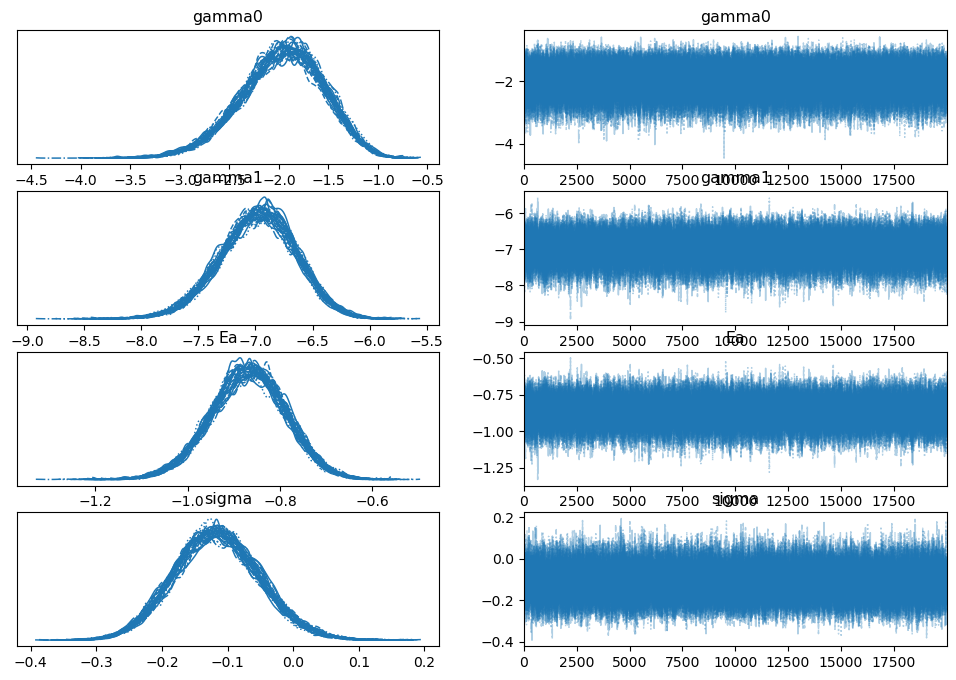

Bayes parameters:    gamma0=0.152041, gamma1=0.000982511, Ea=0.42101, sigma=0.89252
MLE parameters:      gamma0=0.14481, gamma1=0.000942921, Ea=0.420154, sigma=0.879277
Comparisons: LSQ  -> gamma0=0.14831, gamma1=0.000932207, Ea=0.421228


In [4]:
# 3) Baysian parameter estimation (Gaussian stochastic errors)
# -----------------------------

mu_logg0, sd_logg0 = np.log(gamma0_hat), 0.5
mu_logg1, sd_logg1 = np.log(gamma1_hat), 0.5
mu_logEa, sd_logEa = np.log(Ea_hat), 0.5
mu_logs, sd_logs   = np.log(sig_mle), 0.5

def log_prior(theta):
    log_g0, log_g1, log_Ea, log_sig = theta
    # Normals
    lp  = -0.5*((log_g0 - mu_logg0)/sd_logg0)**2 - np.log(sd_logg0*np.sqrt(2*np.pi))
    lp += -0.5*((log_g1 - mu_logg1)/sd_logg1)**2 - np.log(sd_logg1*np.sqrt(2*np.pi))
    lp += -0.5*((log_sig - mu_logs)/sd_logs)**2 - np.log(sd_logs*np.sqrt(2*np.pi))
    lp += -0.5*((log_Ea - mu_logEa)/sd_logEa)**2 - np.log(sd_logEa*np.sqrt(2*np.pi))
    return lp

def log_likelihood(theta, t_time, T_acc_K, D_obs):
    log_g0, log_g1, log_Ea, log_sig = theta
    g0, g1, sig, Ea= np.exp(log_g0), np.exp(log_g1), np.exp(log_sig), np.exp(log_Ea)
    # guard rails
    if not (np.isfinite(g0) and np.isfinite(g1) and np.isfinite(sig) and np.isfinite(Ea)) or sig <= 0 or Ea <= 0:
        return -np.inf
    mu = mu_D([g0, g1, Ea], t_time, T_acc_K)
    # Gaussian errors on D
    res = D_obs - mu
    ll = -0.5*np.sum((res/sig)**2 + 2.0*np.log(sig) + np.log(2*np.pi))
    return ll

def log_prob(theta, t_time, T_acc_K, D_obs):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, t_time, T_acc_K, D_obs)
    return lp + ll

# Initialize walkers near MLE solution / reasonable scales
init_logg0  = np.log(max(g0_mle, 1e-10))
init_logg1  = np.log(max(g1_mle, 1e-3))
init_logEa  = np.log(max(Ea_mle, 1e-3))
init_logsig = np.log(max(sig_mle, 1e-3))

ndim, nwalkers = 4, 32
rng = np.random.default_rng(123)
p0 = np.array([init_logg0, init_logg1, init_logEa, init_logsig]) + \
     rng.normal(scale=[0.2, 0.1, 0.2, 0.2], size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(t_time, T_acc_K, D_obs))

# Burn-in + sampling
state = sampler.run_mcmc(p0, 10000, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 20000, progress=True)

# Posterior draws (flattened)
chain = sampler.get_chain(flat=True)
log_g0_s, log_g1_s, log_Ea_s, log_sig_s = [chain[:,i] for i in range(ndim)]
g0_s, g1_s, sig_s, Ea_s = np.exp(log_g0_s), np.exp(log_g1_s), np.exp(log_sig_s), np.exp(log_Ea_s)

labels = ["gamma0", "gamma1", "Ea", "sigma"]

# after sampling with emcee or similar:
idata = az.from_emcee(sampler, var_names=labels)

# Get summary with HDI = 95%
az.plot_trace(idata)
plt.show()
#az.plot_pair(idata)

g0_s_mean, g1_s_mean, sig_s_mean, Ea_s_mean = np.mean(g0_s), np.mean(g1_s), np.mean(sig_s), np.mean(Ea_s)
print(f"Bayes parameters:    gamma0={g0_s_mean:.6g}, gamma1={g1_s_mean:.6g}, Ea={Ea_s_mean:.6g}, sigma={sig_s_mean:.6g}")
print(f"MLE parameters:      gamma0={g0_mle:.6g}, gamma1={g1_mle:.6g}, Ea={Ea_mle:.6g}, sigma={sig_mle:.6g}")
print(f"Comparisons: LSQ  -> gamma0={gamma0_hat:.6g}, gamma1={gamma1_hat:.6g}, Ea={Ea_hat:.6g}")

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:43<00:00, 192.68it/s]


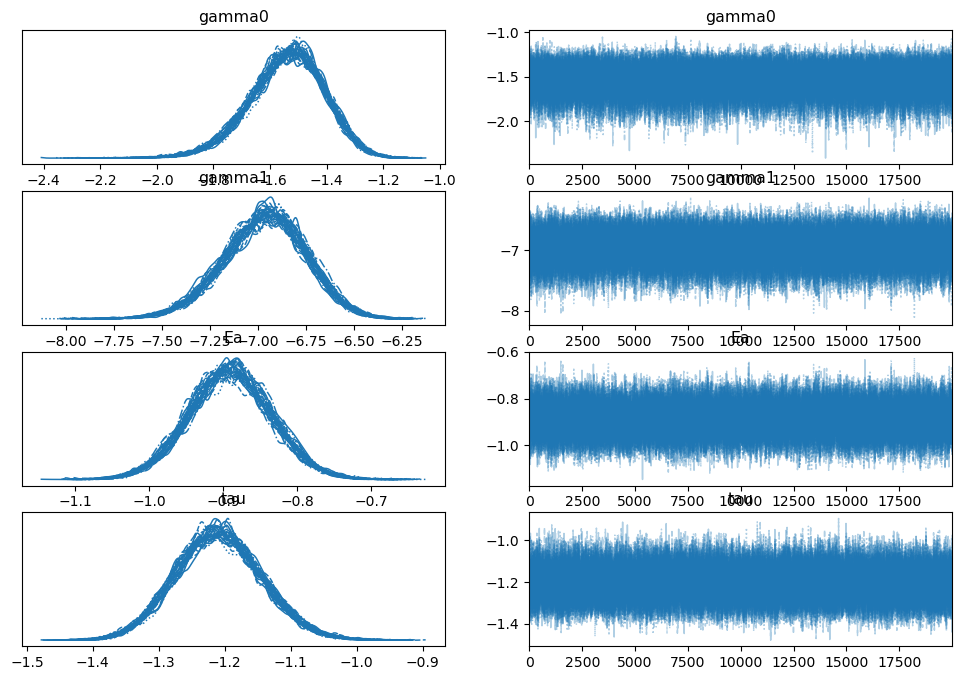

Bayes parameters:
  gamma0 = 0.216005
  gamma1 = 0.000965723
  Ea     = 0.411226
  tau    = 0.299179  (lognormal log-sd)
  beta   = 0.306095  (implied constant CV)
MLE parameters (for reference):
  gamma0 = 0.14481, gamma1 = 0.000942921, Ea = 0.420154


In [5]:
# 3) Bayesian parameter estimation (Lognormal stochastic errors; constant CV)
# --------------------------------------------------------------------------

# Priors centered at your point estimates (log-scale)
mu_logg0, sd_logg0 = np.log(gamma0_hat), 0.5
mu_logg1, sd_logg1 = np.log(gamma1_hat), 0.5
mu_logEa, sd_logEa = np.log(Ea_hat),     0.5

# For lognormal noise, we use tau (log-sd). If you want a rough center, derive
# from residuals on the log scale; otherwise 0.2–0.5 is a reasonable weakly-informative sd.
# Here we set a weak prior centered at tau ~ exp(-1.6) ≈ 0.2 as a mild default.
mu_logtau, sd_logtau = np.log(0.2), 0.5

# Small epsilon to keep logs finite
_EPS = 1e-12

def log_prior(theta):
    log_g0, log_g1, log_Ea, log_tau = theta
    lp  = -0.5*((log_g0 - mu_logg0)/sd_logg0)**2 - np.log(sd_logg0*np.sqrt(2*np.pi))
    lp += -0.5*((log_g1 - mu_logg1)/sd_logg1)**2 - np.log(sd_logg1*np.sqrt(2*np.pi))
    lp += -0.5*((log_Ea - mu_logEa)/sd_logEa)**2 - np.log(sd_logEa*np.sqrt(2*np.pi))
    lp += -0.5*((log_tau - mu_logtau)/sd_logtau)**2 - np.log(sd_logtau*np.sqrt(2*np.pi))
    return lp

def log_likelihood(theta, t_time, T_acc_K, D_obs):
    """
    Lognormal likelihood:
      log D_i ~ Normal( log mu_i - 0.5*tau^2, tau^2 )
    with tau = exp(log_tau). Requires D_obs > 0 and mu_i > 0.
    """
    log_g0, log_g1, log_Ea, log_tau = theta
    g0, g1, Ea, tau = np.exp(log_g0), np.exp(log_g1), np.exp(log_Ea), np.exp(log_tau)

    # Guard rails
    if not (np.isfinite(g0) and np.isfinite(g1) and np.isfinite(Ea) and np.isfinite(tau)):
        return -np.inf
    if tau <= 0 or Ea <= 0 or g0 <= 0 or g1 <= 0:
        return -np.inf

    mu = mu_D([g0, g1, Ea], t_time, T_acc_K)  # model mean on original scale

    # Enforce positivity for log; if your D is strictly in (0,1] this is fine
    m = (mu > 0)
    if not np.all(m):
        return -np.inf
    y = np.log(np.clip(D_obs, _EPS, None))
    mlog = np.log(mu) - 0.5*(tau**2)

    # Gaussian log-likelihood on log scale
    res = y - mlog
    n = y.size
    ll = -0.5*np.sum((res/tau)**2) - n*np.log(tau) - 0.5*n*np.log(2*np.pi)
    return ll

def log_prob(theta, t_time, T_acc_K, D_obs):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, t_time, T_acc_K, D_obs)
    return lp + ll

# ---- Initialization ---------------------------------------------------------

# Start near your MLEs; set tau ~ 0.2 as a mild multiplicative noise guess
init_logg0 = np.log(max(g0_mle, 1e-12))
init_logg1 = np.log(max(g1_mle, 1e-12))
init_logEa = np.log(max(Ea_mle, 1e-12))
init_logtau = np.log(0.2)

ndim, nwalkers = 4, 32
rng = np.random.default_rng(123)
p0 = np.array([init_logg0, init_logg1, init_logEa, init_logtau]) + \
     rng.normal(scale=[0.2, 0.1, 0.2, 0.2], size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(t_time, T_acc_K, D_obs))

# Burn-in + sampling
state = sampler.run_mcmc(p0, 10000, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 20000, progress=True)

# ---- Posterior draws & summaries -------------------------------------------

chain = sampler.get_chain(flat=True)
log_g0_s, log_g1_s, log_Ea_s, log_tau_s = [chain[:, i] for i in range(ndim)]
g0_s, g1_s, Ea_s, tau_s = np.exp(log_g0_s), np.exp(log_g1_s), np.exp(log_Ea_s), np.exp(log_tau_s)

# Constant CV implied by tau: beta = sqrt(exp(tau^2) - 1)
beta_s = np.sqrt(np.exp(tau_s**2) - 1.0)

labels = ["gamma0", "gamma1", "Ea", "tau"]
idata = az.from_emcee(sampler, var_names=labels)

az.plot_trace(idata)
plt.show()

print(f"Bayes parameters:")
print(f"  gamma0 = {np.mean(g0_s):.6g}")
print(f"  gamma1 = {np.mean(g1_s):.6g}")
print(f"  Ea     = {np.mean(Ea_s):.6g}")
print(f"  tau    = {np.mean(tau_s):.6g}  (lognormal log-sd)")
print(f"  beta   = {np.mean(beta_s):.6g}  (implied constant CV)")

print(f"MLE parameters (for reference):")
print(f"  gamma0 = {g0_mle:.6g}, gamma1 = {g1_mle:.6g}, Ea = {Ea_mle:.6g}")


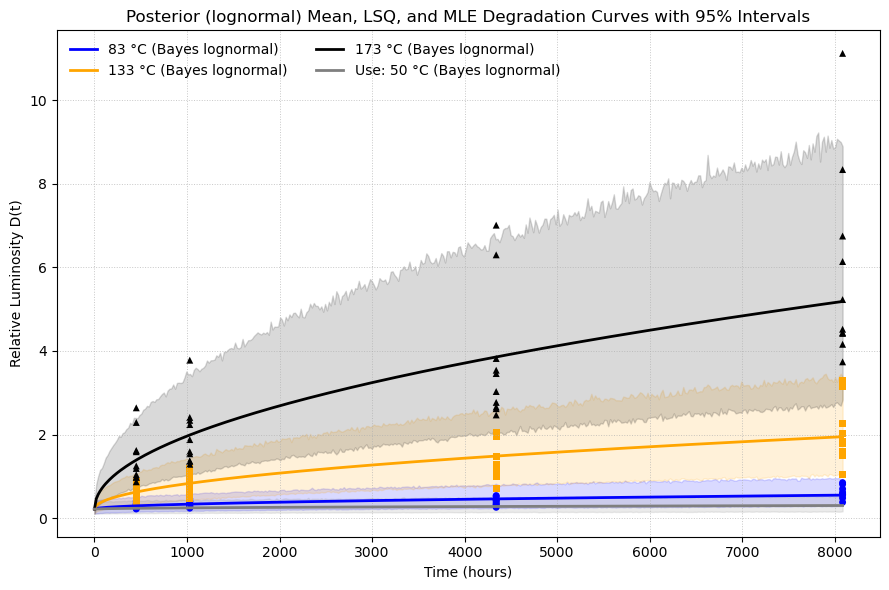

In [57]:
# 4) Parameter estimate validation visualization (Lognormal errors; constant CV)
# -----------------------------------------------------------------------------

# Time grid for smooth curves
t_grid = np.linspace(0.0, np.max(t_time), 400)

use_C = T_use - 273.0
plot_temps_C = [83.0, 133.0, 173.0]
_plot_temps_C = [83.0, 133.0, 173.0, use_C]

# Randomly thin posterior draws for computational efficiency
rng = np.random.default_rng(7)
ns = min(2000, len(g0_s))
sel = rng.choice(len(g0_s), size=ns, replace=False)
_g0  = g0_s[sel]
_g1  = g1_s[sel]
_Ea  = Ea_s[sel]
_tau = tau_s[sel]     # <-- lognormal log-sd draws (replaces _sig)

fig, ax = plt.subplots(figsize=(9, 6))

# # --- LSQ point-estimate degradation curves (solid) ---
# for Tc_lsq in plot_temps_C:
#     color_lsq = TEMP_COLORS.get(Tc_lsq, 'tab:gray')
#     T_eval_lsq = Tc_lsq + 273.15
#     mu_lsq = mu_D([gamma0_hat, gamma1_hat, Ea_hat], t_grid, T_eval_lsq)
#     ax.plot(t_grid, mu_lsq, linestyle='-', linewidth=1, color=color_lsq, label=f"{int(Tc_lsq)} °C (LSQ)")

# # --- MLE point-estimate degradation curves (dash-dot) ---
# for Tc_mle in plot_temps_C:
#     color_mle = TEMP_COLORS.get(Tc_mle, 'tab:gray')
#     T_eval_mle = Tc_mle + 273.15
#     mu_mle = mu_D([g0_mle, g1_mle, Ea_mle], t_grid, T_eval_mle)
#     ax.plot(t_grid, mu_mle, linestyle='-.', linewidth=2, color=color_mle, label=f"{int(Tc_mle)} °C (MLE)")

# --- Posterior mean and 95% intervals (parameter + predictive) ---
for Tc in _plot_temps_C:
    T_eval = Tc + 273.15

    # Compute the model mean for EVERY draw using your actual mu_D
    # (vectorized via list->stack to avoid broadcasting mistakes)
    mu_draws = np.vstack([
        mu_D([g0i, g1i, Eai], t_grid, T_eval)
        for g0i, g1i, Eai in zip(_g0, _g1, _Ea)
    ])  # shape: (ns, len(t_grid))

    # Posterior mean of the MEAN curve (parameter uncertainty only)
    mu_mean = mu_draws.mean(axis=0)

    # 95% CrI for the MEAN curve (parameter uncertainty only)
    lo_mean, hi_mean = np.quantile(mu_draws, [0.025, 0.975], axis=0)

    # Posterior predictive draws (adds lognormal observation noise; constant CV)
    # y = mu * exp( Normal(-0.5*tau^2, tau) )
    eps = rng.normal(loc=-(0.5 * (_tau[:, None]**2)), scale=_tau[:, None], size=mu_draws.shape)
    y_draws = mu_draws * np.exp(eps)

    # 95% posterior predictive interval (asymmetric on original scale)
    lo_pred, hi_pred = np.quantile(y_draws, [0.025, 0.975], axis=0)

    color = TEMP_COLORS.get(Tc, 'tab:gray')
    label = f"{int(Tc)} °C (Bayes lognormal)" if Tc != use_C else f"Use: {int(use_C)} °C (Bayes lognormal)"

    # Plot the posterior mean curve
    ax.plot(t_grid, mu_mean, color=color, linewidth=2, label=label)

    # Show predictive band as a light fill (now asymmetric)
    ax.fill_between(t_grid, lo_pred, hi_pred, alpha=0.15, color=color, label=None)

# --- Overlay scatter data points ---
for temp_c, gtemp in long.sort_values(['Temperature_C', 'Unit', 'hours']).groupby('Temperature_C'):
    color  = TEMP_COLORS.get(temp_c, 'tab:gray')
    marker = TEMP_MARKERS.get(temp_c, 'o')
    ax.scatter(gtemp['hours'].values, gtemp['pct_increase'].values, s=25, marker=marker,
               edgecolors='none', color=color)

# --- Final plot styling ---
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Relative Luminosity D(t)')
ax.set_title('Posterior (lognormal) Mean, LSQ, and MLE Degradation Curves with 95% Intervals')
ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
ax.legend(frameon=False, ncol=2, loc='best')
# plt.yscale("log")
plt.tight_layout()
plt.show()


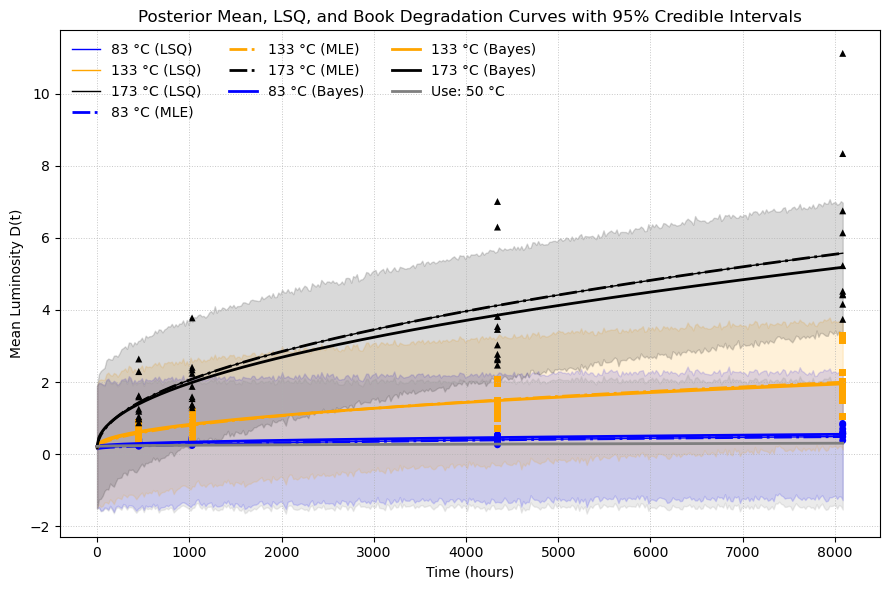

In [18]:
# 4) Parameter estimate validation visualization (Gaussian stochastic errors)
# -----------------------------

# Time grid for smooth curves
t_grid = np.linspace(0.0, np.max(t_time), 400)

use_C = T_use - 273.0
plot_temps_C = [83.0, 133.0, 173.0]
_plot_temps_C = [83.0, 133.0, 173.0, use_C]

# Randomly thin posterior draws for computational efficiency
rng = np.random.default_rng(7)
ns = min(2000, len(g0_s))
sel = rng.choice(len(g0_s), size=ns, replace=False)
_g0 = g0_s[sel]; _g1 = g1_s[sel]; _Ea = Ea_s[sel]; _sig = sig_s[sel]

fig, ax = plt.subplots(figsize=(9, 6))

# --- LSQ point-estimate degradation curves (dotted) ---
for Tc_lsq in plot_temps_C:
    color_lsq = TEMP_COLORS.get(Tc_lsq, 'tab:gray')
    T_eval_lsq = Tc_lsq + 273.15
    mu_lsq = mu_D([gamma0_hat, gamma1_hat, Ea_hat], t_grid, T_eval_lsq)
    ax.plot(t_grid, mu_lsq, linestyle='-', linewidth=1, color=color_lsq, label=f"{int(Tc_lsq)} °C (LSQ)")
    
# --- MLE point-estimate degradation curves (dash-dot) ---
for Tc_mle in plot_temps_C:
    color_mle = TEMP_COLORS.get(Tc_mle, 'tab:gray')
    T_eval_mle = Tc_mle + 273.15
    mu_mle = mu_D([g0_mle, g1_mle, Ea_mle], t_grid, T_eval_mle)
    ax.plot(t_grid, mu_mle, linestyle='-.', linewidth=2, color=color_mle, label=f"{int(Tc_mle)} °C (MLE)")
    
# --- Posterior mean and 95% credible interval bands ---
for Tc in _plot_temps_C:
    T_eval = Tc + 273.15
    accel = np.exp(_Ea[:, None] / K_eV_perK * (1.0 / T_use - 1.0 / T_eval))
    mu_draws = _g0[:, None] + _g1[:, None] * np.sqrt(t_grid[None, :]) * accel
    mu_mean = mu_draws.mean(axis=0)
    color = TEMP_COLORS.get(Tc, 'tab:gray') 
    label = f"{int(Tc)} °C (Bayes)" if Tc != use_C else f"Use: {int(use_C)} °C"
    ax.plot(t_grid, mu_mean, color=color, linewidth=2, label=label)

    # --- Mean curve CrI (parameter uncertainty only) ---
    lo_mean, hi_mean = np.quantile(mu_draws, [0.025, 0.975], axis=0)

    # --- Posterior predictive interval (adds observation noise) ---
    rng = np.random.default_rng(123)
    eps = rng.normal(size=mu_draws.shape)  # standard normals
    y_draws = mu_draws + _sig[:, None] * eps
    lo_pred, hi_pred = np.quantile(y_draws, [0.025, 0.975], axis=0)

    # Show predictive band as a light fill
    ax.fill_between(t_grid, lo_pred, hi_pred, alpha=0.15, color=color, label=None)
    
# --- Overlay scatter data points ---gamma0_hat, gamma1_hat, a_hat
for temp_c, gtemp in long.sort_values(['Temperature_C', 'Unit', 'hours']).groupby('Temperature_C'):
    color  = TEMP_COLORS.get(temp_c, 'tab:gray')
    marker = TEMP_MARKERS.get(temp_c, 'o')
    ax.scatter(gtemp['hours'].values, gtemp['pct_increase'].values, s=25, marker=marker, edgecolors='none', color=color)

# --- Final plot styling ---
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Mean Luminosity D(t)')
ax.set_title('Posterior Mean, LSQ, and Book Degradation Curves with 95% Credible Intervals')
ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
ax.legend(frameon=False, ncol=3, loc='best')
plt.tight_layout()
plt.show()


Posterior summary for TTF (hr):
------------------------------------------------------------
Mean life at use conditions: 29,657,139 hr
Median life:                 25,466,452 hr
95% HDI:                 [4,584,090, 64,531,784] hr
95% ETI:                 [7,890,588, 75,910,097] hr
------------------------------------------------------------


c:\users\leaat\reliability\reliability\Fitters.py:440: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 8000/0 (0% right censored) 

   Distribution       Alpha    Beta       Gamma     Alpha 1  Beta 1     Alpha 2  Beta 2 Proportion 1 DS          Mu       Sigma      Lambda  Log-likelihood   AICc    BIC      AD optimizer
   Lognormal_2P                                                                                             17.0431     0.57557                     -143277 286559 286573 2.37163       TNC
   Lognormal_3P                               0                                                             17.0431     0.57557                     -143277 286561 286582 2.37163       TNC
 Loglogistic_2P  2.5395e+07 3.06607                                                                                                                 -143306 286616 286630 4.24724       TNC
 Loglogistic_3P 2.53696e+07 3.06276     23534.8                                                                                               

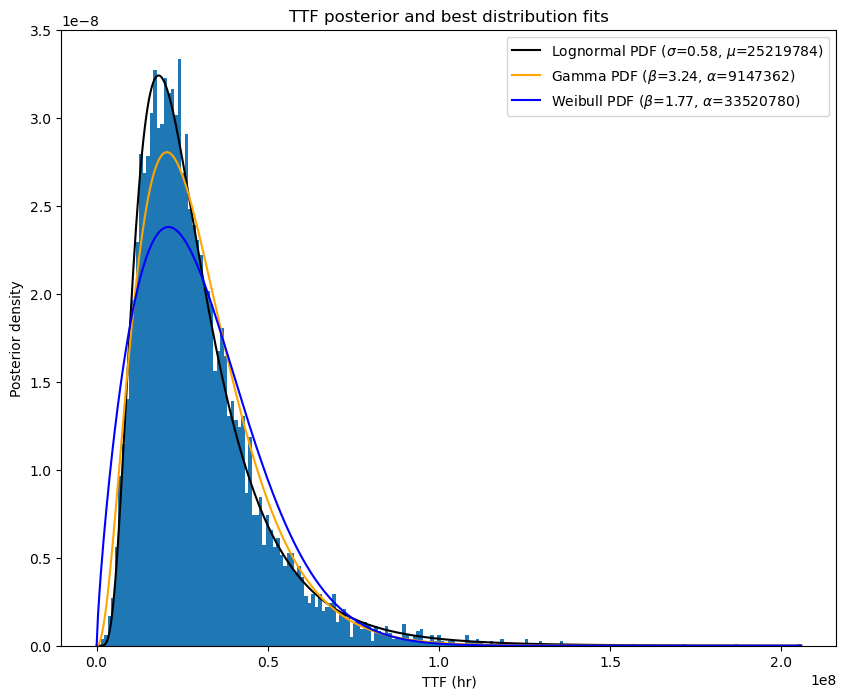

In [8]:
# 5) Posterior TTF PDF visualization
# --------------------------------

def _G_draw_factory(g0, g1, Ea, sig, Df, T_eval):
    accel = np.exp(Ea / K_eV_perK * (1.0/T_use - 1.0/T_eval)) 
    def G_draw(t):
        mu = g0 + g1 * np.sqrt(t) * accel      # or your t-law
        return norm.cdf((mu - Df)/sig)         # correct tail
    return G_draw, accel

def _suggest_t_hi(g0, g1, Df, accel, mult=1.0):
    g0 = max(g0, 1e-30); g1 = max(g1, 1e-12)
    t_det = ((Df - g0) / (g1 * accel))**2
    t_det = np.clip(t_det, 1e-9, 1e12)
    return float(mult * t_det)

def _grow_bracket(G_draw, u, t_hi0, t_hi_max=1e12):
    """Grow t_hi until G_draw(t_hi) >= u (or we give up)."""
    t_hi = max(1.0, t_hi0)
    val = G_draw(t_hi)
    it = 0
    while val < u and t_hi < t_hi_max and it < 60:
        t_hi *= 2.0
        val = G_draw(t_hi)
        it += 1
    return t_hi if val >= u else np.nan

def draw_ttf_with_error(g0_s, g1_s, Ea_s, sig_s, Df, T_eval, n_samps=5000, seed=4):
    rng = np.random.default_rng(seed)
    n_draws = len(g0_s)
    idx = rng.integers(0, n_draws, size=n_samps)
    out = []
    for i in idx:
        g0, g1, Ea, sig = g0_s[i], g1_s[i], Ea_s[i], sig_s[i]
        G_draw, accel = _G_draw_factory(g0, g1, Ea, sig, Df, T_eval)
        u = rng.random()

        if G_draw(0.0) >= u:
            out.append(0.0); continue

        t_hi0 = _suggest_t_hi(g0, g1, Df, accel, mult=10.0)
        t_hi  = _grow_bracket(G_draw, u, t_hi0)
        if not np.isfinite(t_hi):
            t_hi = _grow_bracket(G_draw, u, 1.0)
            if not np.isfinite(t_hi):
                continue

        try:
            t = brentq(lambda t: G_draw(t) - u, 0.0, t_hi, maxiter=200)
            if np.isfinite(t) and t >= 0:
                out.append(t)
        except ValueError:
            continue
    return np.asarray(out)

# --- Sample TTF PDF ---

Df = 5
T_eval = T_use
ttf_err = draw_ttf_with_error(g0_s, g1_s, Ea_s, sig_s, Df, T_eval, n_samps=8000, seed=24)

# --- Print results ---
def summarize_ttf(samples, hdi_prob=0.95, label="TTF (hr)", unit_label="hr"):
    s = np.asarray(samples)
    s = s[np.isfinite(s)]
    mean   = float(s.mean())
    median = float(np.median(s))
    lo, hi = az.hdi(s, hdi_prob=hdi_prob)  # Highest Density Interval
    # Equal-tailed interval too (optional)
    eti_lo, eti_hi = np.percentile(s, [(1-hdi_prob)/2*100, (1-(1-hdi_prob)/2)*100])
    print(f"\nPosterior summary for {label}:\033[0m")
    print("-" * 60)
    print(f"Mean life at use conditions: {mean:,.0f} {unit_label}")
    print(f"Median life:                 {median:,.0f} {unit_label}")
    print(f"{int(hdi_prob*100)}% HDI:                 [{lo:,.0f}, {hi:,.0f}] {unit_label}")
    print(f"{int(hdi_prob*100)}% ETI:                 [{eti_lo:,.0f}, {eti_hi:,.0f}] {unit_label}")
    print("-" * 60)
    return {"mean": mean, "median": median, "hdi": (float(lo), float(hi)), "eti": (float(eti_lo), float(eti_hi))}

summary = summarize_ttf(ttf_err, hdi_prob=0.95, label="TTF (hr)")

# Find best parameters for each Dist
Best_fit = Fit_Everything(failures=ttf_err, show_histogram_plot=False, show_probability_plot=False, show_PP_plot=False, show_best_distribution_probability_plot=False)

# Generate x-values for plotting
x = np.linspace(0.01, np.max(ttf_err), 500)

# Calculate the most common PDFs for visual comparrison 
W_pdf = weibull_min.pdf(x, c=Best_fit.Weibull_2P_beta, scale=Best_fit.Weibull_2P_alpha)
G_pdf = gamma.pdf(x, a=Best_fit.Gamma_2P_beta, scale=Best_fit.Gamma_2P_alpha, loc=0)
L_pdf = lognorm.pdf(x, s=Best_fit.Lognormal_2P_sigma, scale=np.exp(Best_fit.Lognormal_2P_mu), loc=0)

# Plot the PDF
plt.figure(figsize=(10, 8))
plt.hist(ttf_err, bins=200, density=True)
plt.plot(x, L_pdf, c="black", label=fr'Lognormal PDF ($\sigma$={Best_fit.Lognormal_2P_sigma:.2f}, $\mu$={np.exp(Best_fit.Lognormal_2P_mu):.0f})')
plt.plot(x, G_pdf, c="orange", label=fr'Gamma PDF ($\beta$={Best_fit.Gamma_2P_beta:.2f}, $\alpha$={Best_fit.Gamma_2P_alpha:.0f})')
plt.plot(x, W_pdf, c="blue", label=fr'Weibull PDF ($\beta$={Best_fit.Weibull_2P_beta:.2f}, $\alpha$={Best_fit.Weibull_2P_alpha:.0f})')
plt.xlabel("TTF (hr)")
plt.ylabel("Posterior density")
plt.title("TTF posterior and best distribution fits")
plt.legend()
plt.show()

In [35]:
# 3) Hierarchical structure and helpers
# -------------------------------------

# Map units to 0...(J-1)
units = np.sort(long["Unit"].unique())
J = len(units)
unit_index = {u: j for j, u in enumerate(units)}
j_idx = long["Unit"].map(unit_index).to_numpy(int)   # length = N

N = len(D_obs)

print(f"Hierarchical model will use J={J} units and N={N} observations")

def mu_D_unit(theta_j, t, T_accK, T_use=T_use):
    """
    theta_j = (gamma0_j, gamma1_j, Ea_j)
    Degradation model: D = gamma0 + gamma1 * sqrt(t) * accel(T)
    """
    gamma0_j, gamma1_j, Ea_j = theta_j
    accel = np.exp(Ea_j / K_eV_perK * (1.0/T_use - 1.0/T_accK))
    return gamma0_j + gamma1_j * np.sqrt(t) * accel

def unpack_theta(theta, J):
    """
    theta = [mu_g0, log_sig_g0, mu_g1, log_sig_g1, mu_Ea, log_sig_Ea,
             log_sigma_obs,
             gamma0_0..J-1, gamma1_0..J-1, Ea_0..J-1]
    """
    idx = 0
    mu_g0, log_sig_g0 = theta[idx], theta[idx+1]; idx += 2
    mu_g1, log_sig_g1 = theta[idx], theta[idx+1]; idx += 2
    mu_Ea, log_sig_Ea = theta[idx], theta[idx+1]; idx += 2
    log_sigma_obs     = theta[idx];             idx += 1

    gamma0_j = theta[idx       : idx+J]; idx += J
    gamma1_j = theta[idx       : idx+J]; idx += J
    Ea_j     = theta[idx       : idx+J]; idx += J

    sig_g0  = np.exp(log_sig_g0)
    sig_g1  = np.exp(log_sig_g1)
    sig_Ea  = np.exp(log_sig_Ea)
    sigma_y = np.exp(log_sigma_obs)

    return (mu_g0, sig_g0, mu_g1, sig_g1, mu_Ea, sig_Ea,
            sigma_y,
            gamma0_j, gamma1_j, Ea_j)

def log_joint_hier(theta, t_vec, T_vec, D_vec, j_idx, J):
    """
    Joint log-likelihood for:
    - Data given per-unit parameters and observation noise
    - Per-unit parameters given population means/SDs (random-effects layer)
    """
    (mu_g0, sig_g0, mu_g1, sig_g1, mu_Ea, sig_Ea,
     sigma_y,
     gamma0_j, gamma1_j, Ea_j) = unpack_theta(theta, J)

    # Guard rails on SDs and physically-meaningful ranges
    if (sig_g0 <= 0) or (sig_g1 <= 0) or (sig_Ea <= 0) or (sigma_y <= 0):
        return -np.inf
    if np.any(gamma1_j <= 0) or np.any(Ea_j <= 0) or np.any(gamma0_j < 0):
        return -np.inf

    # --- Likelihood: D ~ N(mu_D(theta_j), sigma_y) ---
    # One pass through data
    mu_vec = np.empty_like(D_vec, dtype=float)
    for j in range(J):
        m = (j_idx == j)
        if not np.any(m):
            continue
        mu_vec[m] = mu_D_unit((gamma0_j[j], gamma1_j[j], Ea_j[j]),
                              t_vec[m], T_vec[m])
    # Numerical guard
    if not np.all(np.isfinite(mu_vec)):
        return -np.inf

    ll_data = log_likelihood_lognormal(D_vec, mu_vec, sigma_y)

    # --- Random-effects layer: per-unit parameters ~ Normal(pop_mean, pop_sd) ---
    ll_re  = np.sum(norm.logpdf(gamma0_j, loc=mu_g0, scale=sig_g0))
    ll_re += np.sum(norm.logpdf(gamma1_j, loc=mu_g1, scale=sig_g1))
    ll_re += np.sum(norm.logpdf(Ea_j,     loc=mu_Ea, scale=sig_Ea))

    return ll_data + ll_re
    
def log_likelihood_lognormal(D_vec, mu_vec, sigma):
    """
    Log-likelihood for lognormal observation error:
        ln(y) = ln(D) + eps, eps ~ N(0, sigma^2)

    p(y|D,sigma) = 1/(y*sigma) * phi((ln(y)-ln(D))/sigma)
    """
    if sigma <= 0:
        return -np.inf
    if np.any(D_vec <= 0) or np.any(mu_vec <= 0):
        return -np.inf

    z = (np.log(D_vec) - np.log(mu_vec)) / sigma
    return (
        -np.sum(np.log(D_vec))        # Jacobian term
        - len(mu_vec) * np.log(sigma)  # scale
        + np.sum(norm.logpdf(z))      # standard normal density
    )
    
def neg_log_joint_hier(theta, t_vec, T_vec, D_vec, j_idx, J):
    val = log_joint_hier(theta, t_vec, T_vec, D_vec, j_idx, J)
    if not np.isfinite(val):
        return 1e100
    return -val

Hierarchical model will use J=29 units and N=116 observations


In [36]:
# 3.1) Initial values based on LSQ solution
mu_g0_init  = gamma0_hat
mu_g1_init  = gamma1_hat
mu_Ea_init  = Ea_hat

# small between-unit variation to start
sig_g0_init = 0.1 * abs(mu_g0_init) if mu_g0_init != 0 else 0.1
sig_g1_init = 0.3 * abs(mu_g1_init) if mu_g1_init != 0 else 0.3
sig_Ea_init = 0.3 * abs(mu_Ea_init) if mu_Ea_init != 0 else 0.3

sigma_y_init = rms  # from your LSQ residual RMS

gamma0_init = np.full(J, mu_g0_init)
gamma1_init = np.full(J, mu_g1_init)
Ea_init     = np.full(J, mu_Ea_init)

theta0 = np.concatenate([
    [mu_g0_init, np.log(sig_g0_init),
     mu_g1_init, np.log(sig_g1_init),
     mu_Ea_init, np.log(sig_Ea_init),
     np.log(sigma_y_init)],
    gamma0_init, gamma1_init, Ea_init
])

print("dim(theta0) =", theta0.size)


dim(theta0) = 94


In [39]:
res_hier_mle = minimize(neg_log_joint_hier,theta0, args=(t_time, T_acc_K, D_obs, j_idx, J), method="L-BFGS-B", options=dict(maxiter=2000, disp=True))

print("\nHierarchical MLE success:", res_hier_mle.success)
print("Message:", res_hier_mle.message)

(theta_hat_mle, (mu_g0_mle, sig_g0_mle, mu_g1_mle, sig_g1_mle, mu_Ea_mle, sig_Ea_mle, sigma_y_mle, gamma0_j_mle, gamma1_j_mle, Ea_j_mle)) = (res_hier_mle.x, unpack_theta(res_hier_mle.x, J))

print(f"\nPopulation means (MLE):")
print(f"  mu_gamma0 = {mu_g0_mle:.4g},  sig_gamma0 = {sig_g0_mle:.4g}")
print(f"  mu_gamma1 = {mu_g1_mle:.4g},  sig_gamma1 = {sig_g1_mle:.4g}")
print(f"  mu_Ea     = {mu_Ea_mle:.4g},  sig_Ea     = {sig_Ea_mle:.4g}")
print(f"  sigma_obs = {sigma_y_mle:.4g}")


Hierarchical MLE success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH

Population means (MLE):
  mu_gamma0 = 0.1483,  sig_gamma0 = 0.01483
  mu_gamma1 = 0.0009322,  sig_gamma1 = 0.0002797
  mu_Ea     = 0.4212,  sig_Ea     = 0.1264
  sigma_obs = 0.8793


MLE parameters:      gamma0=0.14481, gamma1=0.000942921, Ea=0.420154, sigma=0.879277

In [40]:
def population_predictive_curve(t_grid, T_accK, mu_g0, sig_g0, mu_g1, sig_g1, mu_Ea, sig_Ea, T_use, K_eV_perK, n_draws=5000, rng=None):
    """
    Compute population-mean degradation curve

        D_bar(t, s) = E_theta[ D(t, s; theta) ]

    via Monte Carlo:
        - theta = (gamma0, gamma1, Ea)
        - theta ~ Normal(mu, sig^2) (independent components)

    Parameters
    ----------
    t_grid : 1D array
        Times at which to evaluate D_bar(t, s).
    T_accK : float
        Stress temperature in Kelvin (s = stress level).
    mu_g0, sig_g0, mu_g1, sig_g1, mu_Ea, sig_Ea : floats
        Population mean and SD for gamma0, gamma1, Ea (from hierarchical MLE).
    T_use : float
        Use temperature in Kelvin.
    K_eV_perK : float
        Boltzmann constant in eV/K (same as in your D(t, s; theta) model).
    n_draws : int
        Number of Monte Carlo draws for theta.
    rng : np.random.Generator or None
        Optional RNG; if None, a default is created.

    Returns
    -------
    D_mean : 1D array (len(t_grid))
        Population-mean degradation curve.
    D_lo, D_hi : 1D arrays
        2.5% and 97.5% quantiles (optional predictive band).
    """
    if rng is None:
        rng = np.random.default_rng(7)

    t_grid = np.asarray(t_grid, float)
    T_accK = float(T_accK)

    # --- Sample population parameter draws theta^(k) ---
    gamma0_s = rng.normal(mu_g0,  sig_g0,  size=n_draws)
    gamma1_s = rng.normal(mu_g1,  sig_g1,  size=n_draws)
    Ea_s     = rng.normal(mu_Ea,  sig_Ea,  size=n_draws)

    # Enforce basic physical constraints (optional; adjust to taste)
    gamma0_s = np.clip(gamma0_s, 0.0, None)
    gamma1_s = np.clip(gamma1_s, 1e-12, None)
    Ea_s     = np.clip(Ea_s,     1e-12, None)

    # --- Compute D(t, s; theta^(k)) for all draws and times ---
    # accel_k (n_draws,)
    accel_s = np.exp(Ea_s / K_eV_perK * (1.0/T_use - 1.0/T_accK))

    sqrt_t = np.sqrt(t_grid)[None, :]         # (1, T)
    accel_s_2d = accel_s[:, None]             # (n_draws, 1)

    # Broadcast:
    # gamma0_s[:,None] + gamma1_s[:,None]*sqrt_t*accel_s_2d
    D_draws = gamma0_s[:, None] + gamma1_s[:, None] * sqrt_t * accel_s_2d
    # shape: (n_draws, len(t_grid))

    # --- Monte Carlo expectation and bands ---
    D_mean = np.nanmean(D_draws, axis=0)
    D_lo   = np.nanpercentile(D_draws, 2.5, axis=0)
    D_hi   = np.nanpercentile(D_draws, 97.5, axis=0)

    return D_mean, D_lo, D_hi

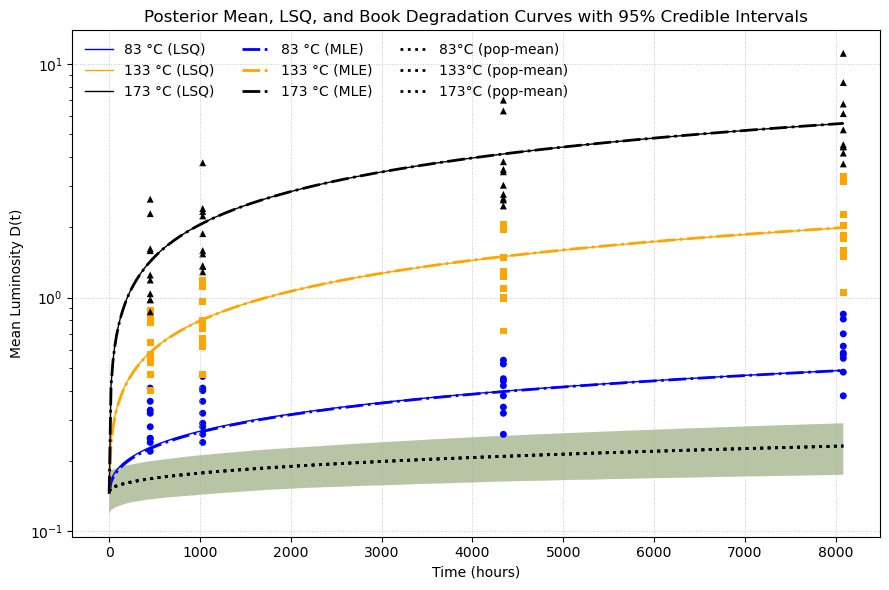

In [47]:
# 4) Parameter estimate validation visualization (Gaussian stochastic errors)
# -----------------------------

# Time grid for smooth curves
t_grid = np.linspace(0.0, np.max(t_time), 400)

use_C = T_use - 273.0
plot_temps_C = [83.0, 133.0, 173.0]
_plot_temps_C = [83.0, 133.0, 173.0, use_C]

# Randomly thin posterior draws for computational efficiency
rng = np.random.default_rng(7)
ns = min(2000, len(g0_s))
sel = rng.choice(len(g0_s), size=ns, replace=False)
_g0 = g0_s[sel]; _g1 = g1_s[sel]; _Ea = Ea_s[sel]; _sig = sig_s[sel]

fig, ax = plt.subplots(figsize=(9, 6))

# --- LSQ point-estimate degradation curves (dotted) ---
for Tc_lsq in plot_temps_C:
    color_lsq = TEMP_COLORS.get(Tc_lsq, 'tab:gray')
    T_eval_lsq = Tc_lsq + 273.15
    mu_lsq = mu_D([gamma0_hat, gamma1_hat, Ea_hat], t_grid, T_eval_lsq)
    ax.plot(t_grid, mu_lsq, linestyle='-', linewidth=1, color=color_lsq, label=f"{int(Tc_lsq)} °C (LSQ)")
    
# --- MLE point-estimate degradation curves (dash-dot) ---
for Tc_mle in plot_temps_C:
    color_mle = TEMP_COLORS.get(Tc_mle, 'tab:gray')
    T_eval_mle = Tc_mle + 273.15
    mu_mle = mu_D([g0_mle, g1_mle, Ea_mle], t_grid, T_eval_mle)
    ax.plot(t_grid, mu_mle, linestyle='-.', linewidth=2, color=color_mle, label=f"{int(Tc_mle)} °C (MLE)")

# --- MLE population-estimate degradation curves (dash-dot) ---
for Tc in plot_temps_C:
    color_mle = TEMP_COLORS.get(Tc_mle, 'tab:gray')
    T_eval_mle = Tc_mle + 273.15
    D_mean, D_lo, D_hi = population_predictive_curve(
        t_grid,
        T_use,
        mu_g0_mle, sig_g0_mle,
        mu_g1_mle, sig_g1_mle,
        mu_Ea_mle, sig_Ea_mle,
        T_use,
        K_eV_perK,
        n_draws=5000
    )

    ax.plot(t_grid, D_mean, linestyle=':', linewidth=2, color=color_mle, label=f"{Tc:.0f}°C (pop-mean)")
    ax.fill_between(t_grid, D_lo, D_hi, alpha=0.2)
    
# # --- Posterior mean and 95% credible interval bands ---
# for Tc in _plot_temps_C:
#     T_eval = Tc + 273.15
#     accel = np.exp(_Ea[:, None] / K_eV_perK * (1.0 / T_use - 1.0 / T_eval))
#     mu_draws = _g0[:, None] + _g1[:, None] * np.sqrt(t_grid[None, :]) * accel
#     mu_mean = mu_draws.mean(axis=0)
#     color = TEMP_COLORS.get(Tc, 'tab:gray') 
#     label = f"{int(Tc)} °C (Bayes)" if Tc != use_C else f"Use: {int(use_C)} °C"
#     ax.plot(t_grid, mu_mean, color=color, linewidth=2, label=label)

#     # --- Mean curve CrI (parameter uncertainty only) ---
#     lo_mean, hi_mean = np.quantile(mu_draws, [0.025, 0.975], axis=0)

#     # --- Posterior predictive interval (adds observation noise) ---
#     rng = np.random.default_rng(123)
#     eps = rng.normal(size=mu_draws.shape)  # standard normals
#     y_draws = mu_draws + _sig[:, None] * eps
#     lo_pred, hi_pred = np.quantile(y_draws, [0.025, 0.975], axis=0)

#     # Show predictive band as a light fill
#     ax.fill_between(t_grid, lo_pred, hi_pred, alpha=0.15, color=color, label=None)
    
# --- Overlay scatter data points ---gamma0_hat, gamma1_hat, a_hat
for temp_c, gtemp in long.sort_values(['Temperature_C', 'Unit', 'hours']).groupby('Temperature_C'):
    color  = TEMP_COLORS.get(temp_c, 'tab:gray')
    marker = TEMP_MARKERS.get(temp_c, 'o')
    ax.scatter(gtemp['hours'].values, gtemp['pct_increase'].values, s=25, marker=marker, edgecolors='none', color=color)

# --- Final plot styling ---
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Mean Luminosity D(t)')
ax.set_title('Posterior Mean, LSQ, and Book Degradation Curves with 95% Credible Intervals')
ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
ax.legend(frameon=False, ncol=3, loc='best')
plt.yscale("log")
plt.tight_layout()
plt.show()